In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
cd "../input/mnist-npy-file-dataset"

/kaggle/input/mnist-npy-file-dataset


In [3]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Available")
  dev = torch.device('cuda')
  print(dev)

Available
cuda


In [4]:
data = np.load("train_images.npy")
data = data/255
data = torch.Tensor(data).to(dev)
data[0][0]

tensor(0., device='cuda:0')

In [5]:
class RBM(torch.nn.Module):
  
  def __init__(self, v_size=784, h_size=256, k=[1], lr=0.1):
    super(RBM, self).__init__()
    self.W = torch.Tensor(torch.randn(v_size, h_size)).to(dev)
    self.v_bias = torch.Tensor(torch.zeros(1, v_size)).to(dev)
    self.h_bias = torch.Tensor(torch.zeros(1, h_size)).to(dev)
    self.k = k
    self.lr = lr
    self.sample_v = False
    self.sample_h = True




  def sample_h_given_v(self, vis):
    htensor = torch.matmul(vis, self.W) + self.h_bias
    activation = torch.sigmoid(htensor)

    if self.sample_h == False:
      return activation, activation

    else:
      h_dist = torch.distributions.Bernoulli(activation)
      sampled_h = h_dist.sample()
      return activation, sampled_h




  def sample_v_given_h(self, hid):
    vtensor = torch.matmul(hid, self.W.T) + self.v_bias
    activation = torch.sigmoid(vtensor)

    if self.sample_v == False:
      return activation

    else:
      activation = torch.distributions.Bernoulli(activation)
      sampled_v = activation.sample()
      return sampled_v




  def energy(self, vis):
    _, hidden = self.sample_h_given_v(vis)
    val = torch.matmul(vis, self.v_bias.T) + torch.matmul(hidden, self.h_bias.T) + torch.matmul(torch.matmul(hidden.T, self.W), vis)
    
    return -val




  def contrastive_divergence(self,input_data,k,batch_size):
    vis = input_data

    for i in range(k):
      hid, sample_hid = self.sample_h_given_v(vis)
      vis = self.sample_v_given_h(sample_hid)

    pos_phase, _ = self.sample_h_given_v(input_data)
    neg_phase, _ = self.sample_h_given_v(vis)

    self.W += (self.lr)*(torch.matmul(input_data.T, pos_phase) - torch.matmul(vis.T, neg_phase))
    self.v_bias += (self.lr/batch_size)*torch.sum(input_data - vis, dim=0)
    self.h_bias += (self.lr/batch_size)*torch.sum(pos_phase - neg_phase,dim=0)

    return vis




  def train(self, data, epochs=1, batch_size=1):
    for ks in self.k:
      print("k: ",ks)

      for epoch in range(epochs):
        error = 0

        for i in range(0,len(data),batch_size):
          batch_image = data[i:i+batch_size]
          recon_v = self.contrastive_divergence(batch_image,ks,batch_size)

          diff = recon_v - batch_image
          diff = torch.mul(diff,diff)
          error += torch.sum(diff)

        print("Epoch: ",epoch+1,"   reconstruction_loss: ",(error/batch_size).detach().item())




  def reconstruct(self, test_img):
    recon_k = 1
    recon_v = self.contrastive_divergence(test_img,recon_k,batch_size=1)

    return recon_v

In [6]:
rbm = RBM(h_size=256, lr=0.001, k=[10])
rbm.train(data,epochs=270, batch_size=1000)

k:  10
Epoch:  1    reconstruction_loss:  6692.974609375
Epoch:  2    reconstruction_loss:  5275.5966796875
Epoch:  3    reconstruction_loss:  5109.28564453125
Epoch:  4    reconstruction_loss:  4651.33544921875
Epoch:  5    reconstruction_loss:  4647.71435546875
Epoch:  6    reconstruction_loss:  4460.88916015625
Epoch:  7    reconstruction_loss:  4208.9951171875
Epoch:  8    reconstruction_loss:  4260.18701171875
Epoch:  9    reconstruction_loss:  3977.37255859375
Epoch:  10    reconstruction_loss:  3900.971923828125
Epoch:  11    reconstruction_loss:  4069.677001953125
Epoch:  12    reconstruction_loss:  3815.359130859375
Epoch:  13    reconstruction_loss:  3758.84716796875
Epoch:  14    reconstruction_loss:  3700.908447265625
Epoch:  15    reconstruction_loss:  3694.347900390625
Epoch:  16    reconstruction_loss:  3780.8369140625
Epoch:  17    reconstruction_loss:  3607.935302734375
Epoch:  18    reconstruction_loss:  3530.60498046875
Epoch:  19    reconstruction_loss:  3744.385986

# Now let's test our generated images and compare them with real data

<Figure size 432x288 with 0 Axes>

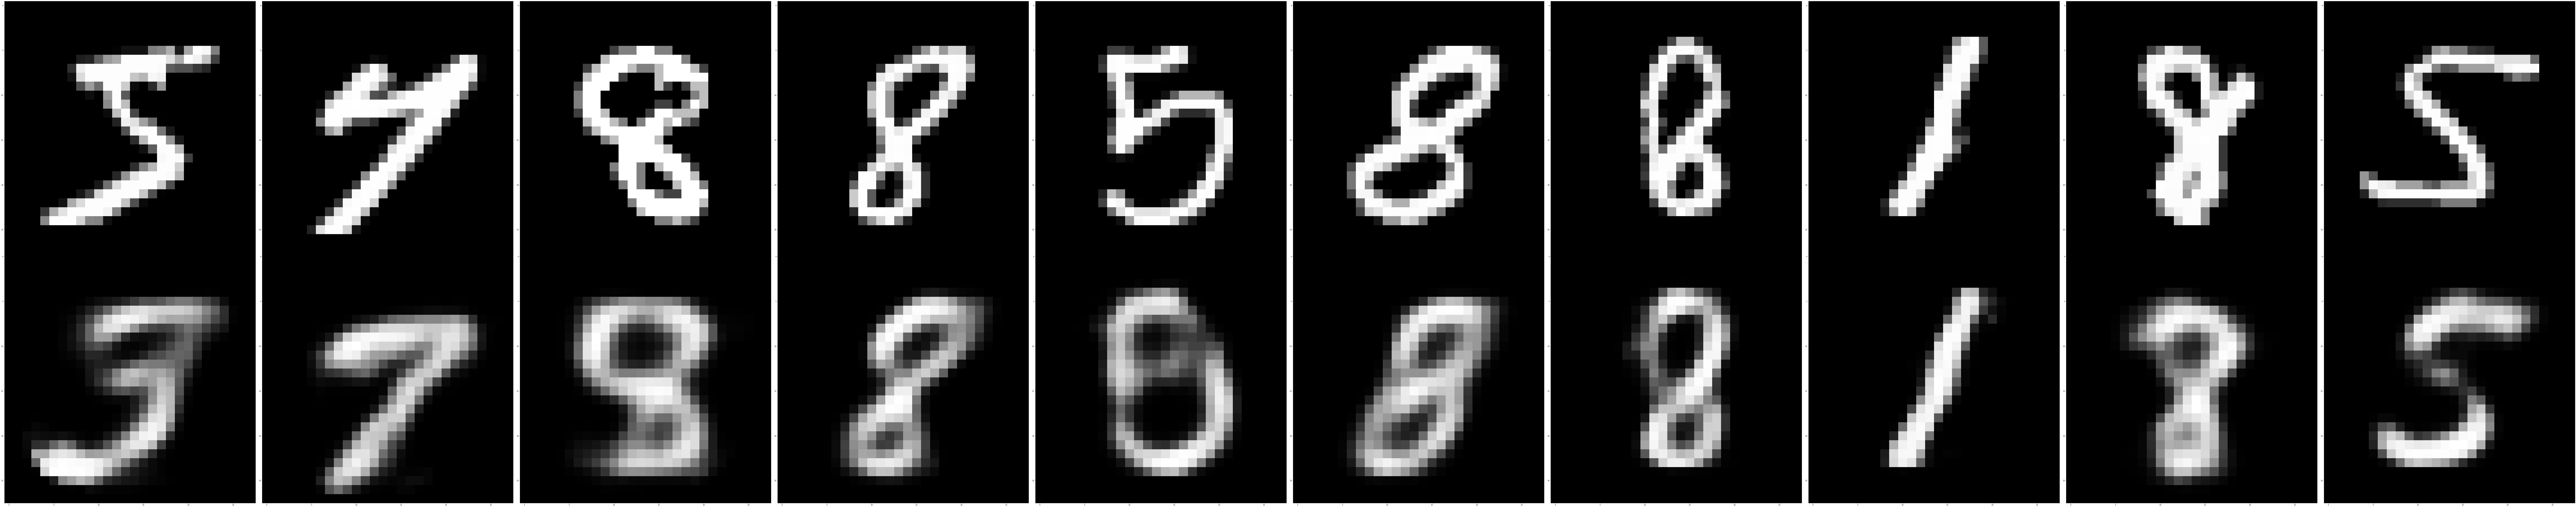

In [7]:
plt.figure()
f,ax = plt.subplots(2,10,figsize=(280, 56),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(10):
  b = data[i*1000 + i]
  b = b.view(1,784)
  cpu_b = b
  ax[0,i].imshow(np.reshape(cpu_b.cpu().numpy(),(28,28)),cmap='gray')
  new_b = rbm.reconstruct(b)
  ax[1,i].imshow(np.reshape(new_b.cpu().numpy(),(28,28)),cmap='gray')

<Figure size 432x288 with 0 Axes>

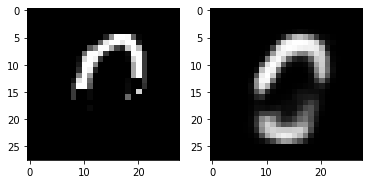

In [8]:
clip_b = [[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  36, 146,
        254, 255, 251,  95,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  97,
        234, 254, 254, 232, 254, 254,  35,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  89,
        140, 254, 254, 174,  67,  33, 200, 254, 190,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        108, 253, 254, 235,  51,   1,   0,   0,  12, 254, 253,  56,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  12, 216, 254, 244,  55,   0,   0,   0,   0,   6, 213, 254,
         57,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  25, 254, 254, 132,   0,   0,   0,   0,   0,   0,
        168, 254,  57,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  45, 254, 243,  34,   0,   0,   0,   0,
          0,   0, 168, 254,  57,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 128, 254, 157,   0,   0,   0,
          0,   0,   0,   0, 168, 254,  57,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  19, 228, 254, 105,   0,
          0,   0,   0,   0,   0,   7, 0, 0,  57,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58, 254, 254,
         87,   0,   0,   0,   0,   0,   0,  10, 0, 0,  47,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58,
        0, 0,   9,   0,   0,   0,   0,   0,   0,  10, 0, 210,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  58, 0, 0,   9,   0,   0,   0,   0,   0,   0, 105, 0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  0, 0, 0,   0,   0,   0,   0,   0,   0,  0,
        0, 0,  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 0, 0,   9,   0,   0,   0,   0,
          0,  0, 0, 0,  0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 0, 0,  0,   0,   0,
          0,   0,  0, 0, 0,  0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 0, 0, 0,
          0,   0,   0,   0, 0, 0, 0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  0,
        0, 0,  0,   0,   0,  0, 0, 0,  0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  0, 0, 0, 0,  0, 0, 0, 0, 0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  0, 0, 0, 0, 0, 0, 0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 0, 0, 0, 0, 0,  0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]]


clip_b = torch.Tensor(clip_b).to(dev)
cpu_clip_b = clip_b
plt.figure()
f,ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(cpu_clip_b.cpu().numpy(),(28,28)),cmap='gray')
recon_clip_b = rbm.reconstruct(clip_b)
ax[1].imshow(np.reshape(recon_clip_b.cpu().numpy(),(28,28)),cmap='gray')